In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lr_utils import load_dataset

In [2]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

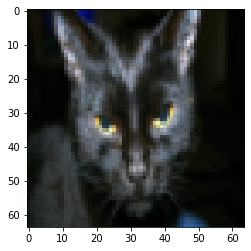

In [3]:
index = 25
plt.imshow(train_set_x_orig[index])

In [4]:
#打印出当前的训练标签值
#使用np.squeeze的目的是压缩维度，【未压缩】train_set_y[:,index]的值为[1] , 【压缩后】np.squeeze(train_set_y[:,index])的值为1
#print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")
#只有压缩后的值才能进行解码操作
print("y=" + str(train_set_y[:,index]) + ", it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

y=[1], it's a cat' picture


In [5]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

#现在看一看我们加载的东西的具体情况
print ("训练集的数量: m_train = " + str(m_train))
print ("测试集的数量 : m_test = " + str(m_test))
print ("每张图片的宽/高 : num_px = " + str(num_px))
print ("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集_图片的维数: " + str(test_set_x_orig.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


In [6]:
#X_flatten = X.reshape(X.shape[0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [7]:
print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


In [8]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

![img1](https://imgconvert.csdnimg.cn/aHR0cHM6Ly9pbWctYmxvZy5jc2RuLm5ldC8yMDE4MDMyMTE1NTgzNDc3ND93YXRlcm1hcmsvMi90ZXh0L0x5OWliRzluTG1OelpHNHVibVYwTDNVd01UTTNNek16TWpZPS9mb250LzVhNkw1TDJUL2ZvbnRzaXplLzQwMC9maWxsL0kwSkJRa0ZDTUE9PS9kaXNzb2x2ZS83MA?x-oss-process=image/format,png)

In [10]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。

    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [11]:
# 测试sigmoid()
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [12]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。

        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）

        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    # 使用断言来确保我要的数据是正确的
    assert w.shape == (dim, 1)
    assert isinstance(b, float) or isinstance(b, int)
    return w, b

In [14]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]

    # 正向传播
    A = sigmoid(np.dot(w.T, X) + b) # 计算激活值
    cost = (-1 /m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) # 计算成本

    # 反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    # 使用断言确保我的数据是正确的
    assert dw.shape == w.shape
    assert db.dtype == float
    cost = np.squeeze(cost)
    assert cost.shape == ()

    # 创建一个字典，把dw和db保存起来
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        # 记录成本
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("迭代的次数: %i ， 误差值： %f" % (i, cost))

    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    return params, grads, costs

In [26]:
def predict(w, b, X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # 预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    assert Y_prediction.shape == (1, m)

    return Y_prediction

就目前而言，我们基本上把所有的东西都做完了，现在我们要把这些函数统统整合到一个model()函数中，届时只需要调用一个model()就基本上完成所有的事了。

In [27]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从字典“参数”中检索参数w和b
    w, b = parameters['w'], parameters['b']

    # 预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)

    # 打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")
    d = {"costs" : costs,
        "Y_prediction_test" : Y_prediction_test,
        "Y_prediciton_train" : Y_prediction_train,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations" : num_iterations }
    return d

In [28]:
print("====================测试model====================")
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


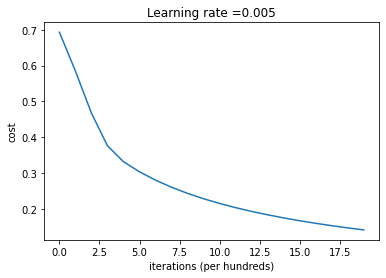

In [29]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Learning rate =' + str(d['learning_rate']))
plt.show()

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 70.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 91.38755980861244 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 71.29186602870814 %
测试集准确性： 40.0 %

-------------------------------------------------------



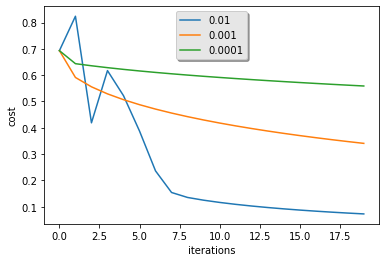

In [30]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for lr in learning_rates:
    print('learning rate is: {}'.format(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]['costs']), label=str(models[str(lr)]['learning_rate']))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()